<a href="https://colab.research.google.com/github/harryguiacorn/colab/blob/main/Generate_1hr_cloud_signal_and_charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance ta pandas matplotlib mpl_finance mplfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=c3847419cc4838a01fa4e415c113611c19b3c1e5fb16aadfff5915d378dae9f8
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


# Download 1h data and generator cloud signals

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
from ta.trend import IchimokuIndicator
import os

# Define the trading pair (USD/JPY) and specify the period and interval
symbol = 'ES=F'
period = '6mo'  # Last 6 months
interval = '1h'


def create_folder(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
folder_path_csv = f"output/csv/{symbol}/"
create_folder(folder_path_csv)

# Fetch hourly data for the specified period
data = yf.download(symbol, period=period, interval=interval)

# Create an IchimokuIndicator instance
ichimoku = IchimokuIndicator(data['High'], data['Low'])

# Calculate Ichimoku values
data['Ichimoku_A'] = ichimoku.ichimoku_a().shift(26)  # Shift back by 26 periods
data['Ichimoku_B'] = ichimoku.ichimoku_b().shift(26)  # Shift back by 26 periods

# Create the 'Cloud' column based on Ichimoku values
data['Cloud'] = np.where((data['Close'] > data['Ichimoku_A']) & (data['Close'] > data['Ichimoku_B']), 1,
                         np.where((data['Close'] < data['Ichimoku_A']) & (data['Close'] < data['Ichimoku_B']), -1, 0))

# Export data to a CSV file
csv_filename = f'{folder_path_csv}/{symbol}_hourly_cloud_data_6_months.csv'
data.to_csv(csv_filename)
print(f"Hourly data for {symbol} over the last 6 months with Ichimoku cloud values exported to {csv_filename}")

# Filter the data for the specified time range (09:00 - 11:00)
filtered_data = data.between_time('04:00', '15:00') # EST time

folder_path_img = f"output/img/{symbol}/"
create_folder(folder_path_img)

# Create and save candlestick charts for each day in the specified time range
for date, group in filtered_data.groupby(filtered_data.index.date):
    # Extract the date and time
    date_str = date.strftime('%Y-%m-%d')
    time_str = group.index[0].strftime('%H-%M')

    # Define the filename for the saved chart
    chart_filename = f'{symbol}_{date_str}_{time_str}_candlestick_chart.png'

    # Create the candlestick chart using mplfinance
    chart_path = f"{folder_path_img}{chart_filename}"
    mpf.plot(group, type='candle', savefig=chart_path, title=f'{symbol} {date} {interval} Candlestick Chart', style='yahoo')

    print(f"Candlestick chart for {symbol} on {date} saved as {chart_path}")


[*********************100%%**********************]  1 of 1 completed
Hourly data for ES=F over the last 6 months with Ichimoku cloud values exported to output/csv/ES=F//ES=F_hourly_cloud_data_6_months.csv
Candlestick chart for ES=F on 2023-05-03 saved as output/img/ES=F/ES=F_2023-05-03_13-00_candlestick_chart.png
Candlestick chart for ES=F on 2023-05-04 saved as output/img/ES=F/ES=F_2023-05-04_04-00_candlestick_chart.png
Candlestick chart for ES=F on 2023-05-05 saved as output/img/ES=F/ES=F_2023-05-05_04-00_candlestick_chart.png
Candlestick chart for ES=F on 2023-05-08 saved as output/img/ES=F/ES=F_2023-05-08_04-00_candlestick_chart.png
Candlestick chart for ES=F on 2023-05-09 saved as output/img/ES=F/ES=F_2023-05-09_04-00_candlestick_chart.png
Candlestick chart for ES=F on 2023-05-10 saved as output/img/ES=F/ES=F_2023-05-10_04-00_candlestick_chart.png
Candlestick chart for ES=F on 2023-05-11 saved as output/img/ES=F/ES=F_2023-05-11_04-00_candlestick_chart.png
Candlestick chart for ES=

[*********************100%%**********************]  1 of 1 completed


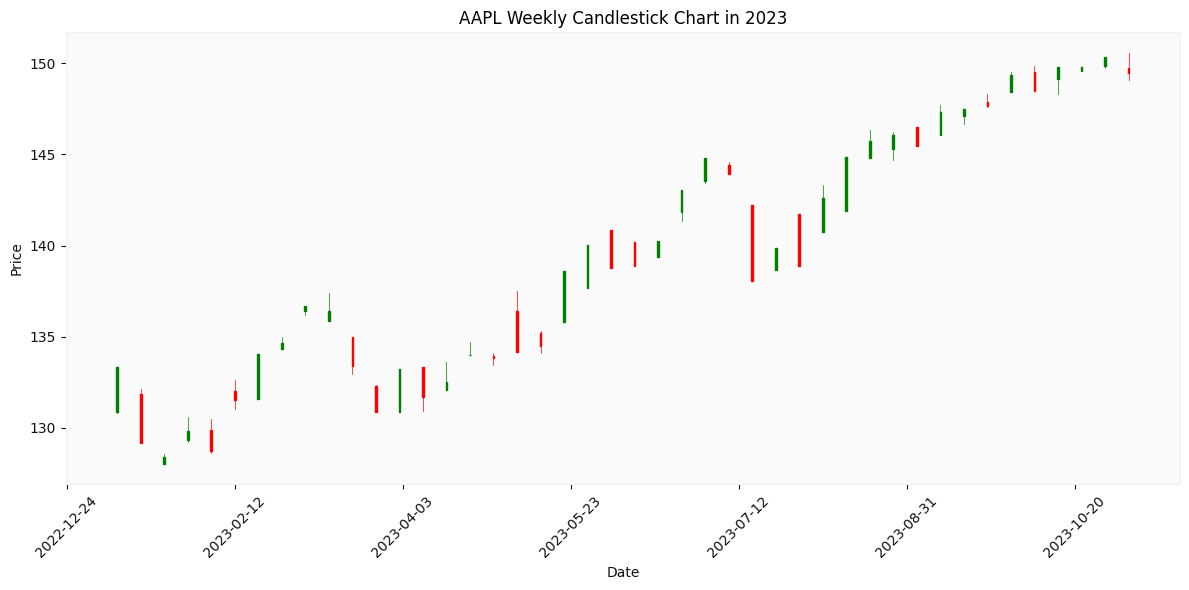

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

# Define the stock symbol (AAPL for Apple Inc.)
stock_symbol = "JPY=X"

# Define the date range for the data
start_date = "2023-01-01"
end_date = "2023-12-31"

# Download the data from Yahoo Finance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Resample the data to weekly OHLC
ohlc_data = data['Adj Close'].resample('W').ohlc()
ohlc_data.reset_index(inplace=True)
ohlc_data['Date'] = ohlc_data['Date'].map(mdates.date2num)

# Plot the Candlestick Chart
candlestick_ohlc(ax, ohlc_data.values, width=0.5, colorup='g', colordown='r')

# Add labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('AAPL Weekly Candlestick Chart')

# Format the x-axis to show dates nicely
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid()
plt.tight_layout()
plt.show()
